In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

print("Path to dataset files:", path)

100%|██████████| 98.7M/98.7M [00:00<00:00, 182MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1


In [4]:
!cp -r /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1 ./

In [42]:

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # Used for converting labels to one-hot encoding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.data import AUTOTUNE

In [58]:
train_data=image_dataset_from_directory(
    '/content/1/melanoma_cancer_dataset/train',
    labels='inferred',
    image_size=(128,128),
    label_mode='int',
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    seed=42
    )

Found 9605 files belonging to 2 classes.


In [44]:
test_data=image_dataset_from_directory(
    '/content/1/melanoma_cancer_dataset/test',
    labels='inferred',
    image_size=(128,128),
    label_mode='int',
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    seed=42
    )

Found 1000 files belonging to 2 classes.


In [45]:
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [59]:
train_data.class_names , train_data.element_spec

(['benign', 'malignant'],
 (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

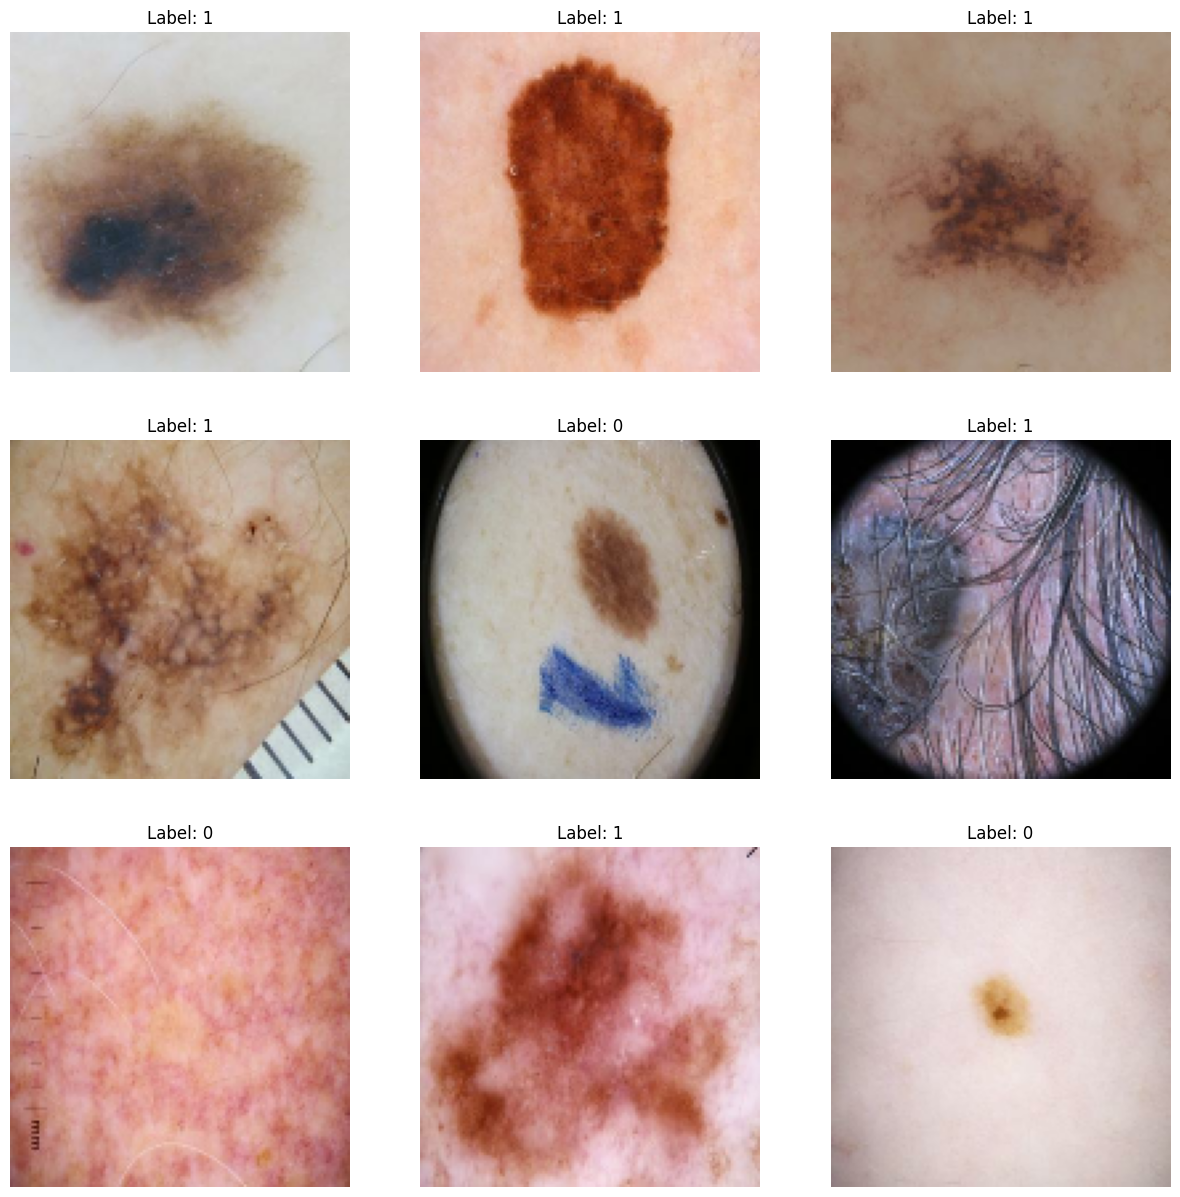

In [47]:
# Get a batch of images and labels
for images, labels in train_data.take(1):  # take(1) gets one batch
    break  # exit after getting the first batch of data

# Visualize the first 9 images from the batch
plt.figure(figsize=(15, 15))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i+1)  # Create a 3x3 grid of images
    plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy array for plotting
    plt.title(f"Label: {labels[i].numpy()}")  # Show the label for each image
    plt.axis("off")  # Hide axis

plt.show()


In [48]:
# Normalize the images
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_data_nor= train_data.map(normalize_img)
test_data_nor= test_data.map(normalize_img)


In [49]:
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,          # Random rotation between 0 and 20 degrees
    width_shift_range=0.2,      # Random horizontal shift by up to 20% of the image width
    height_shift_range=0.2,     # Random vertical shift by up to 20% of the image height
    shear_range=0.2,            # Random shearing transformation
    zoom_range=0.2,             # Random zoom in and out
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill any gaps with the nearest pixel value
)

In [50]:
train_nor=datagen.flow_from_directory(
    '/content/1/melanoma_cancer_dataset/train',
    target_size=(128,128),
    batch_size=64,
    class_mode='binary',
)
test_nor=datagen.flow_from_directory(
    '/content/1/melanoma_cancer_dataset/test',
    target_size=(128,128),
    batch_size=64,
    class_mode='binary',
)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [51]:
# Define the CNN model
model = Sequential([
    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=((128,128,3))),
    # Max pooling: reduces the spatial dimensions (down-sampling)
    MaxPooling2D(pool_size=(2, 2)),
    # Second convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    # Max pooling again to reduce the size further
    MaxPooling2D(pool_size=(2, 2)),
    # Third convolutional layer: 128 filters, 3x3 kernel, ReLU activation
    Conv2D(128, (3, 3), activation='relu'),
    # Max pooling once more
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten the 3D output of the last pooling layer into a 1D vector
    Flatten(),
    # Fully connected layer with 128 neurons and ReLU activation
    Dense(128, activation='relu'),
    # Dropout: randomly drops 50% of the neurons to prevent overfitting
    Dropout(0.5),
    # Output layer with 2 neurons (benign and malignant) and softmax activation for classification
    Dense(1, activation='sigmoid')  # 2 classes: benign and malignant
])

In [52]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 128)      

In [54]:
early_stopping = EarlyStopping(monitor='val_loss',  patience=2, min_delta=0.01, restore_best_weights=True,mode='auto')
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

In [55]:
history=model.fit(train_data_nor,epochs=10,batch_size=32,validation_data=test_data_nor,callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
151/151 [==============================] - 227s 1s/step - loss: 0.4758 - accuracy: 0.7735 - val_loss: 0.4391 - val_accuracy: 0.7820
Epoch 2/10
151/151 [==============================] - 223s 1s/step - loss: 0.3140 - accuracy: 0.8658 - val_loss: 0.2628 - val_accuracy: 0.8810
Epoch 3/10
151/151 [==============================] - 224s 1s/step - loss: 0.2852 - accuracy: 0.8779 - val_loss: 0.2628 - val_accuracy: 0.8990
Epoch 4/10
151/151 [==============================] - 221s 1s/step - loss: 0.2633 - accuracy: 0.8882 - val_loss: 0.2436 - val_accuracy: 0.8980
Epoch 5/10
151/151 [==============================] - 220s 1s/step - loss: 0.2559 - accuracy: 0.8925 - val_loss: 0.2320 - val_accuracy: 0.9070
Epoch 6/10
151/151 [==============================] - 220s 1s/step - loss: 0.2503 - accuracy: 0.8954 - val_loss: 0.2276 - val_accuracy: 0.9020
Epoch 7/10
151/151 [==============================] - 220s 1s/step - loss: 0.2370 - accuracy: 0.9013 - val_loss: 0.2170 - val_accuracy: 0.9060

In [56]:
test_loss, test_accuracy = model.evaluate(test_nor, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 [==============================] - 9s 520ms/step - loss: 0.2814 - accuracy: 0.8850
Test Loss: 0.2814
Test Accuracy: 0.8850


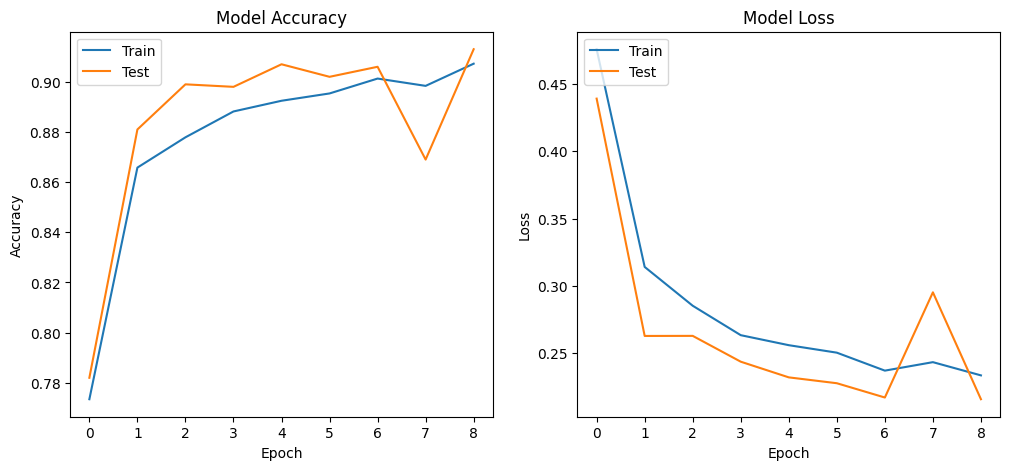

In [57]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
